n
# Analyzing Music Reviews

Our topic is analyzing music reviews from a website called Rate Your Music. On this site, users can write reviews on music albums of various genres, eras, and artists. This topic is interesting because each person and album is unique, however by analyzing the data we can uncover trends, patterns, and factors that drive the success of an album. The topic is also important in that these conclusions can contribute to greater studies about human behaviors and psychology concerning music. Lastly, music is an art form and thus serves as a reflection of society, culture, and individual experiences.

## References

1. DeAngelis, T. (2020, November 1). [Music’s power over our brains](https://www.apa.org/monitor/2020/11/news-music-power). Monitor on Psychology, 51(8).
2. Levitin, D. J., Grahn, J. A., & London, J. (2017, October 16). [The Psychology of Music: Rhythm and movement](https://www.annualreviews.org/doi/abs/10.1146/annurev-psych-122216-011740). Annual Reviews.

## Data Introduction

The data for our project is sourced from Rate Your Music (RYM), a community-driven music database and review platform. It comprises user-generated reviews, ratings, and metadata about various albums across genres. From Rate Your Music, we scraped the following data for each album: title, artist, release year, genres, average user ratings, amount of ratings received, and album descriptors. The dataset is large with over 100,000 album entries, providing a comprehensive foundation for our analysis.

## Group Member's Duties

### Brevinh
- Overseeing the entire project workflow.
- Ensuring data is properly prepared for analysis.
- Coordinating between team members.
- Troubleshooting issues.

### Emma
- Conducting the actual analysis of the music reviews.
- Identifying trends and patterns.
- Interpreting the results.

### Troy
- Studying the related references.
- Understanding the impact of music on our brains.
- Applying these insights to the analysis.

### Jasper
- Synthesizing the work of the entire team into a cohesive report.
- Ensuring that the project's findings are communicated.
- Reviewing and editing the final report for clarity and coherence.
```

In [1]:
from bs4 import BeautifulSoup
import os
import sqlite3
import pandas as pd
import progressbar

In [2]:
def treat_ratings_and_reviews(string):
    """
    Clean ratings and reviews data.

    Parameters:
        string (str): The input string containing ratings or reviews.

    Returns:
        int: Cleaned integer value representing ratings or reviews.
    """
    subject = str(string).strip() or "0"
    subject = subject.replace(",", "")
    return int(subject)


def convert_month_to_number(word_month):
    """
    Convert month name to its numeric representation.

    Parameters:
        word_month (str): Name of the month.

    Returns:
        int: Numeric representation of the month.
        
    Raises:
        Exception: If the input month is invalid.
    """
    months = [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
    for i in range(0, len(months)):
        if word_month == months[i]:
            return i + 1

    raise Exception("Invalid Month Error")


def convert_date_to_numeric(date):
    """
    Convert date string to numeric format.

    Parameters:
        date (str): Date string in a specific format.

    Returns:
        str: Numeric representation of the date in mm/dd/yyyy format.
    """
    date_split = date.split(" ")
    year = 2000
    month = 1
    day = 1
    for i in range(0, len(date_split)):
        current_index = len(date_split) - (i + 1)
        if i == 0:
            year = date_split[current_index]
        elif i == 1:
            numeric_month = convert_month_to_number(date_split[current_index])
            month = numeric_month
        elif i == 2:
            day = date_split[current_index]

    return f"{month}/{day}/{year}"


def get_text_from_links(div, class_name):
    """
    Extract text from links within a given element.

    Parameters:
        div (bs4.element.Tag): BeautifulSoup Tag object.
        class_name (str): Class name of the links.

    Returns:
        list: List of text extracted from links.
    """
    result = []
    links = div.find_all("a", class_=class_name)
    for link in links:
        link_text = link.get_text()
        result.append(link_text)
    return result


def get_text_from_nested_span(parent, class_name):
    """
    Extract text from a nested span within a given element.

    Parameters:
        parent (bs4.element.Tag): Parent BeautifulSoup Tag object.
        class_name (str): Class name of the nested span.

    Returns:
        str: Text extracted from the nested span.
    """
    span = parent.find("span", class_=class_name)
    if span:
        nested_span = span.find("span", class_="full")
        if nested_span:
            return nested_span.get_text()
    return None


def get_descriptors(descriptor_div):
    """
    Extract descriptors from a given element.

    Parameters:
        descriptor_div (bs4.element.Tag): Descriptor div BeautifulSoup Tag object.

    Returns:
        list or None: List of descriptors extracted.
    """
    result = []
    if not descriptor_div:
        return None
    comma_separated_spans = descriptor_div.find_all("span", class_="comma_separated")
    for span in comma_separated_spans:
        result.append(span.text)

    return result


def get_genres(genre_div):
    """
    Extract genres from a given element.

    Parameters:
        genre_div (bs4.element.Tag): Genre div BeautifulSoup Tag object.

    Returns:
        list or None: List of genres extracted.
    """
    if not genre_div:
        return None
    return get_text_from_links(genre_div, "genre comma_separated")


class AlbumScraper:
    def __init__(self, album_div):
        self.album = album_div

    def get_album_data(self):
        """
        Get data of an album from its div element.

        Returns:
            dict: Dictionary containing album data.
        """
        album_title_div = self.album.find(
            "div", class_="page_charts_section_charts_item_title"
        )
        album_title = album_title_div.find(
            "span", class_="ui_name_locale_original"
        ).text
        artist_name_a = self.album.find("a", class_="artist")

        if artist_name_a:
            artist_name_span = artist_name_a.find(
                "span", class_="ui_name_locale_original"
            ) or artist_name_a.find("span", class_="ui_name_locale")
            artist_name = (
                artist_name_span.text if artist_name_span else "Various Artists"
            )
        else:
            artist_name = "Various Artists"
        genre_div = self.album.find(
            "div", class_="page_charts_section_charts_item_genres_primary"
        )
        genre2_div = self.album.find(
            "div", class_="page_charts_section_charts_item_genres_secondary"
        )
        descriptor_div = self.album.find(
            "div", class_="page_charts_section_charts_item_genre_descriptors"
        )
        average_score = self.album.find(
            "span", class_="page_charts_section_charts_item_details_average_num"
        ).text
        if average_score == "":
            average_score = "0"

        date_div = self.album.find("div", class_="page_charts_section_charts_item_date")
        date_span = date_div.find("span")
        date_numeric = convert_date_to_numeric(date_span.text)

        ratings_text = get_text_from_nested_span(
            self.album, "page_charts_section_charts_item_details_ratings"
        )
        reviews_text = get_text_from_nested_span(
            self.album, "page_charts_section_charts_item_details_reviews"
        )
        ratings = treat_ratings_and_reviews(ratings_text)
        reviews = treat_ratings_and_reviews(reviews_text)
        # print(album_title)
        # print(get_genres(genre_div))
        result = {
            "Album_Name": album_title,
            "Artist_Name": artist_name,
            "Genres": get_genres(genre_div),
            "Secondary_Genres": get_genres(genre2_div),
            "Descriptors": get_descriptors(descriptor_div),
            "Average_Rating": float(average_score),
            "Rating_Count": ratings,
            "Review_Count": reviews,
            "Release_Date": date_numeric,
        }
        return result


In [3]:
def scrape_html_file(filepath):
    """
    Scrape album data from an HTML file.

    Parameters:
        filepath (str): Path to the HTML file.

    Returns:
        list: List of dictionaries containing album data.
    """
    result = []
    with open(filepath, "r", encoding="utf-8") as file:
        if not file:
            raise FileNotFoundError
        string = file.read()
        html_soup = BeautifulSoup(string, "html.parser")
        album_divs = html_soup.select("div.page_section_charts_item_wrapper.anchor")
        counter = 0
        for album_div in album_divs:
            counter += 1
            album = AlbumScraper(album_div)
            album_data = album.get_album_data()
            result.append(album_data)

    return result

def walk_directory(directory):
    """
    Walk through a directory, scrape album data from HTML files, and compile it into a DataFrame.

    Parameters:
        directory (str): Path to the directory containing HTML files.

    Returns:
        pandas.DataFrame: DataFrame containing scraped album data.
    """
    all_albums_df = pd.DataFrame()

    for dirpath, dirnames, filenames in os.walk(directory):
        bar = progressbar.ProgressBar(maxval=len(filenames)).start()
        counter = 0
        for filename in filenames:
            bar.update(counter)
            counter += 1
            if filename.endswith(".html"):
                filepath = os.path.join(dirpath, filename)
                page_albums_df = pd.DataFrame(scrape_html_file(filepath))
                
                all_albums_df = pd.concat([all_albums_df, page_albums_df], ignore_index=True)
        bar.finish()

    return all_albums_df



# Clean and Read Data

In [4]:
def clean_data(df):
    """
    Clean the given DataFrame containing album data.

    This function performs the following operations:
    1. Fill missing values for specific columns.
    2. Convert Release_Date to datetime format and format it as '%Y-%m-%d'.
    3. Convert Genres and Descriptors to lists if they are not already.
    4. Convert Average_Rating to float, Rating_Count and Review_Count to integers.
    5. Remove duplicate rows based on subset columns.

    Parameters:
        df (pandas.DataFrame): DataFrame containing album data.

    Returns:
        pandas.DataFrame: Cleaned DataFrame.
    """
    # Fill missing values
    df["Album_Name"].fillna("Unknown", inplace=True)
    df["Artist_Name"].fillna("Unknown", inplace=True)
    df["Release_Date"] = pd.to_datetime(df["Release_Date"]).dt.strftime(
        "%Y-%m-%d"
    )  
    df["Genres"].fillna("None", inplace=True)
    df["Descriptors"].fillna("None", inplace=True)
    df["Average_Rating"].fillna(
        df["Average_Rating"].mean(), inplace=True
    )  
    df["Rating_Count"].fillna(0, inplace=True)
    df["Review_Count"].fillna(0, inplace=True)

    df["Average_Rating"] = df["Average_Rating"].astype(float)
    df["Rating_Count"] = df["Rating_Count"].astype(int)
    df["Review_Count"] = df["Review_Count"].astype(int)

    df["Genres"] = df["Genres"].apply(lambda x: x if isinstance(x, list) else (x.split(",") if x else []))
    df["Descriptors"] = df["Descriptors"].apply(lambda x: x if isinstance(x, list) else (x.split(",") if x else []))

    subset_columns = [
        "Album_Name",
        "Artist_Name",
        "Release_Date",
        "Average_Rating",
        "Rating_Count",
        "Review_Count",
    ]
    df.drop_duplicates(subset=subset_columns, inplace=True)

    return df
    
df = walk_directory('../../HtmlData/TestAlbums')
print(df.head())
clean_data(df)
print(df.head())

                                     Album_Name             Artist_Name  \
0                                    To Be Kind                   Swans   
1                                        Piñata  Freddie Gibbs & Madlib   
2                              Run the Jewels 2          Run the Jewels   
3  N---as on the Moon: The Powers That B Disc 1             Death Grips   
4                                    Salad Days             Mac DeMarco   

                                              Genres  \
0                     [Experimental Rock, Post-Rock]   
1                                      [Gangsta Rap]   
2                                 [Hardcore Hip Hop]   
3  [Experimental Hip Hop, Glitch Hop, Abstract Hi...   
4         [Jangle Pop, Psychedelic Pop, Bedroom Pop]   

                                    Secondary_Genres  \
0             [Noise Rock, Drone, Totalism, No Wave]   
1                          [Jazz Rap, Chipmunk Soul]   
2          [Experimental Hip Hop, Political 

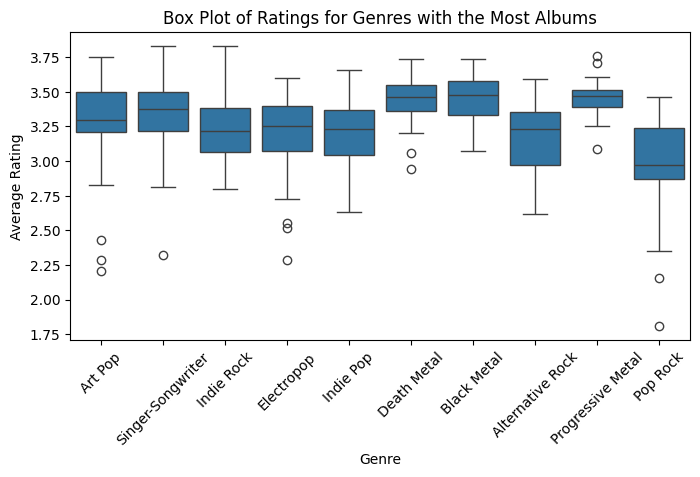

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# calculate the top 10 most frequent genres
top_10_genres = df['Genres'].explode().value_counts().head(10).index

# filter to include only the top 10 genres
top_genres_df = df[df['Genres'].apply(lambda x: any(item for item in top_10_genres if item in x))]

# some albums may have multiple genres
top_genres_df_exploded = top_genres_df.explode('Genres')
top_genres_df_exploded = top_genres_df_exploded[top_genres_df_exploded['Genres'].isin(top_10_genres)]

plt.figure(figsize=(8, 4))
sns.boxplot(x='Genres', y='Average_Rating', data=top_genres_df_exploded)
plt.title('Box Plot of Ratings for Genres with the Most Albums')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()


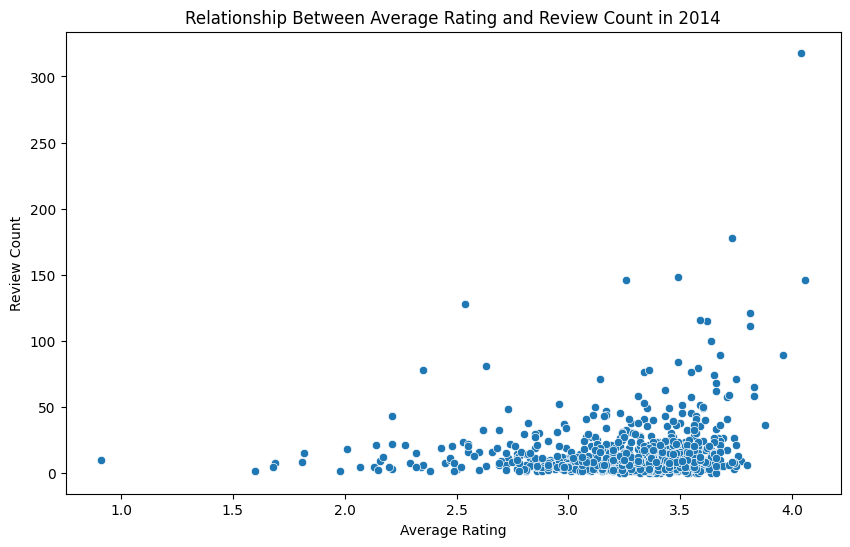

In [6]:
df['Release_Year'] = pd.to_datetime(df['Release_Date']).dt.year
df_2014 = df[df['Release_Year'] == 2014]

# Scatter Plot to analyze the relationship between average ratings and review counts
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average_Rating', y='Review_Count', data=df_2014)
plt.title('Relationship Between Average Rating and Review Count in 2014')
plt.xlabel('Average Rating')
plt.ylabel('Review Count')
plt.show()

### Fitting one statistical model to the data. Explain why you choose this model. Report and interpret the necessary result/visualizaiton for the modeling


In [19]:
import numpy as np

def get_mse(y_true, y_pred):
    """ 
    Calculating the mean squared differnence between actual and expected y-values

    Parameters:
        y_true (np.array): Actual y-values
        y_pred (np.array): Predicted y-values
    """
    return np.mean((y_pred - y_true) ** 2)

def show_fit(x, y, slope, intercept):
    """
    Plot the data and the linear fit.

    Parameters:
        x (list): x values.
        y (list): y values.
        slope (float): Slope of linear fit.
        intercept (float): X-intercept of the linear fit.
    """
    plt.figure()
    
    # transform the input data into numpy arrays and flatten them for easier processing
    x = np.array(x).ravel()
    y = np.array(y).ravel()
    
    # plot the actual data
    plt.scatter(x, y, label='data')
    
    # compute linear predictions 
    # x is a numpy array so each element gets multiplied by slope and intercept is added
    y_pred = slope * x + intercept
    
    # plot the linear fit
    plt.plot(x, y_pred, color='black',
             ls=':',
             label='linear fit')

    plt.legend()
    
    plt.xlabel('Average_Ratings')
    plt.ylabel('Review Counts')
    plt.title("Average_Ratings vs Review Counts (2014) Regression Plot")
    
    # Calculating the mean squared
    y_pred = slope * x + intercept
    mse = get_mse(y_true=y, y_pred=y_pred)
    plt.suptitle(f'y_hat = {slope:.2f} * x + {intercept:.2f}, MSE = {mse:.3f}')


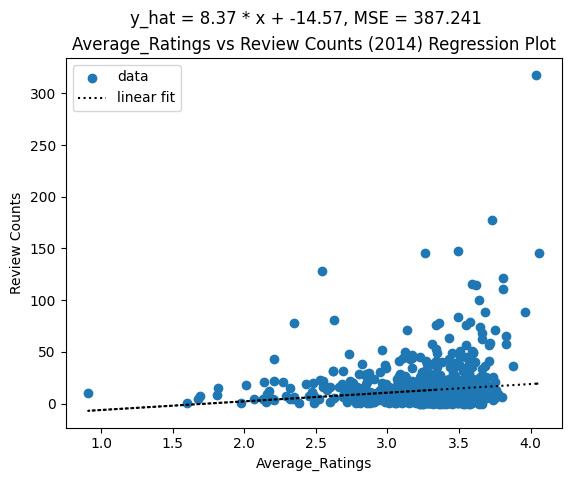

In [20]:
from sklearn.linear_model import LinearRegression

# shaping the data to input in model
x = df_2014['Average_Rating'].values.reshape((-1, 1))
y = df_2014['Review_Count'].values

# initialize linear regression model
reg = LinearRegression()

# fitting average rating and review_count into model
reg.fit(x, y)

slope = reg.coef_[0]
intercept = reg.intercept_

show_fit(x, y, slope, intercept)

We chose a linear regression model since it can be a common assumption that the average ratings of a song will go up with the number of review counts, since popular songs will likely get higher reviews. Through showing this linear regression model, we are able to challenge these assumptions.

To interpert the results of the model, we do not see a strong linear relationship between the average rating and the review counts. This is especially true as the number of average ratings increases. Hence, we can conclude that the relationship between the average ratings and the review counts cannot be accurately described using a linear model. 

### Explain your further analysis plan, and what other analysis you want to include in the report. 



Our further analysis plan would be to try various statistical models to attempt to find trends in the data that we have not found prior. For one, we would like to see what model best represents the relationship between genre and average review.
